In [541]:
# importing relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [542]:
# Loading the dataset
df = pd.read_csv("diabetes_prediction_dataset.csv");

## FEATURE NAME  &  DECRIPTION OF THE DATASET

gender - Gender of the individual (e.g., 'Male', 'Female').

age - Age of the individual in years.

hypertension - Whether the individual has hypertension (0 = No, 1 = Yes).

heart_disease - Whether the individual has heart disease (0 = No, 1 = Yes).

smoking_history - Smoking history of the individual (e.g., 'never', 'former', 'current').

bmi -  Body Mass Index (BMI) of the individual.

HbA1c_level -  Hemoglobin A1c level, indicating average blood sugar levels over the past 3 months.

blood_glucose_level -  Current blood glucose level of the individual.

diabetes -  Target variable indicating whether the individual has diabetes (0 = No, 1 = Yes).

In [544]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### Data Cleaning

In [546]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


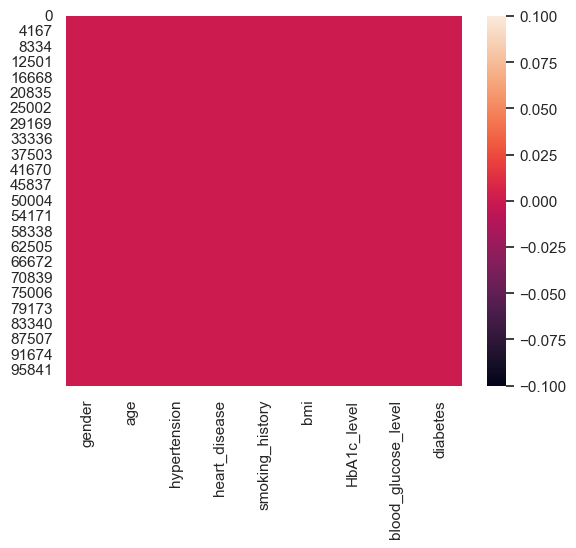

In [547]:
# Reconfirming missing values
df.isnull().sum()
sns.heatmap(df.isnull());

Its clear from the above chart that there are no missing values in the dataset. 

In [549]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


Text(0.5, 1.0, 'Box Plot for HbA1c_level')

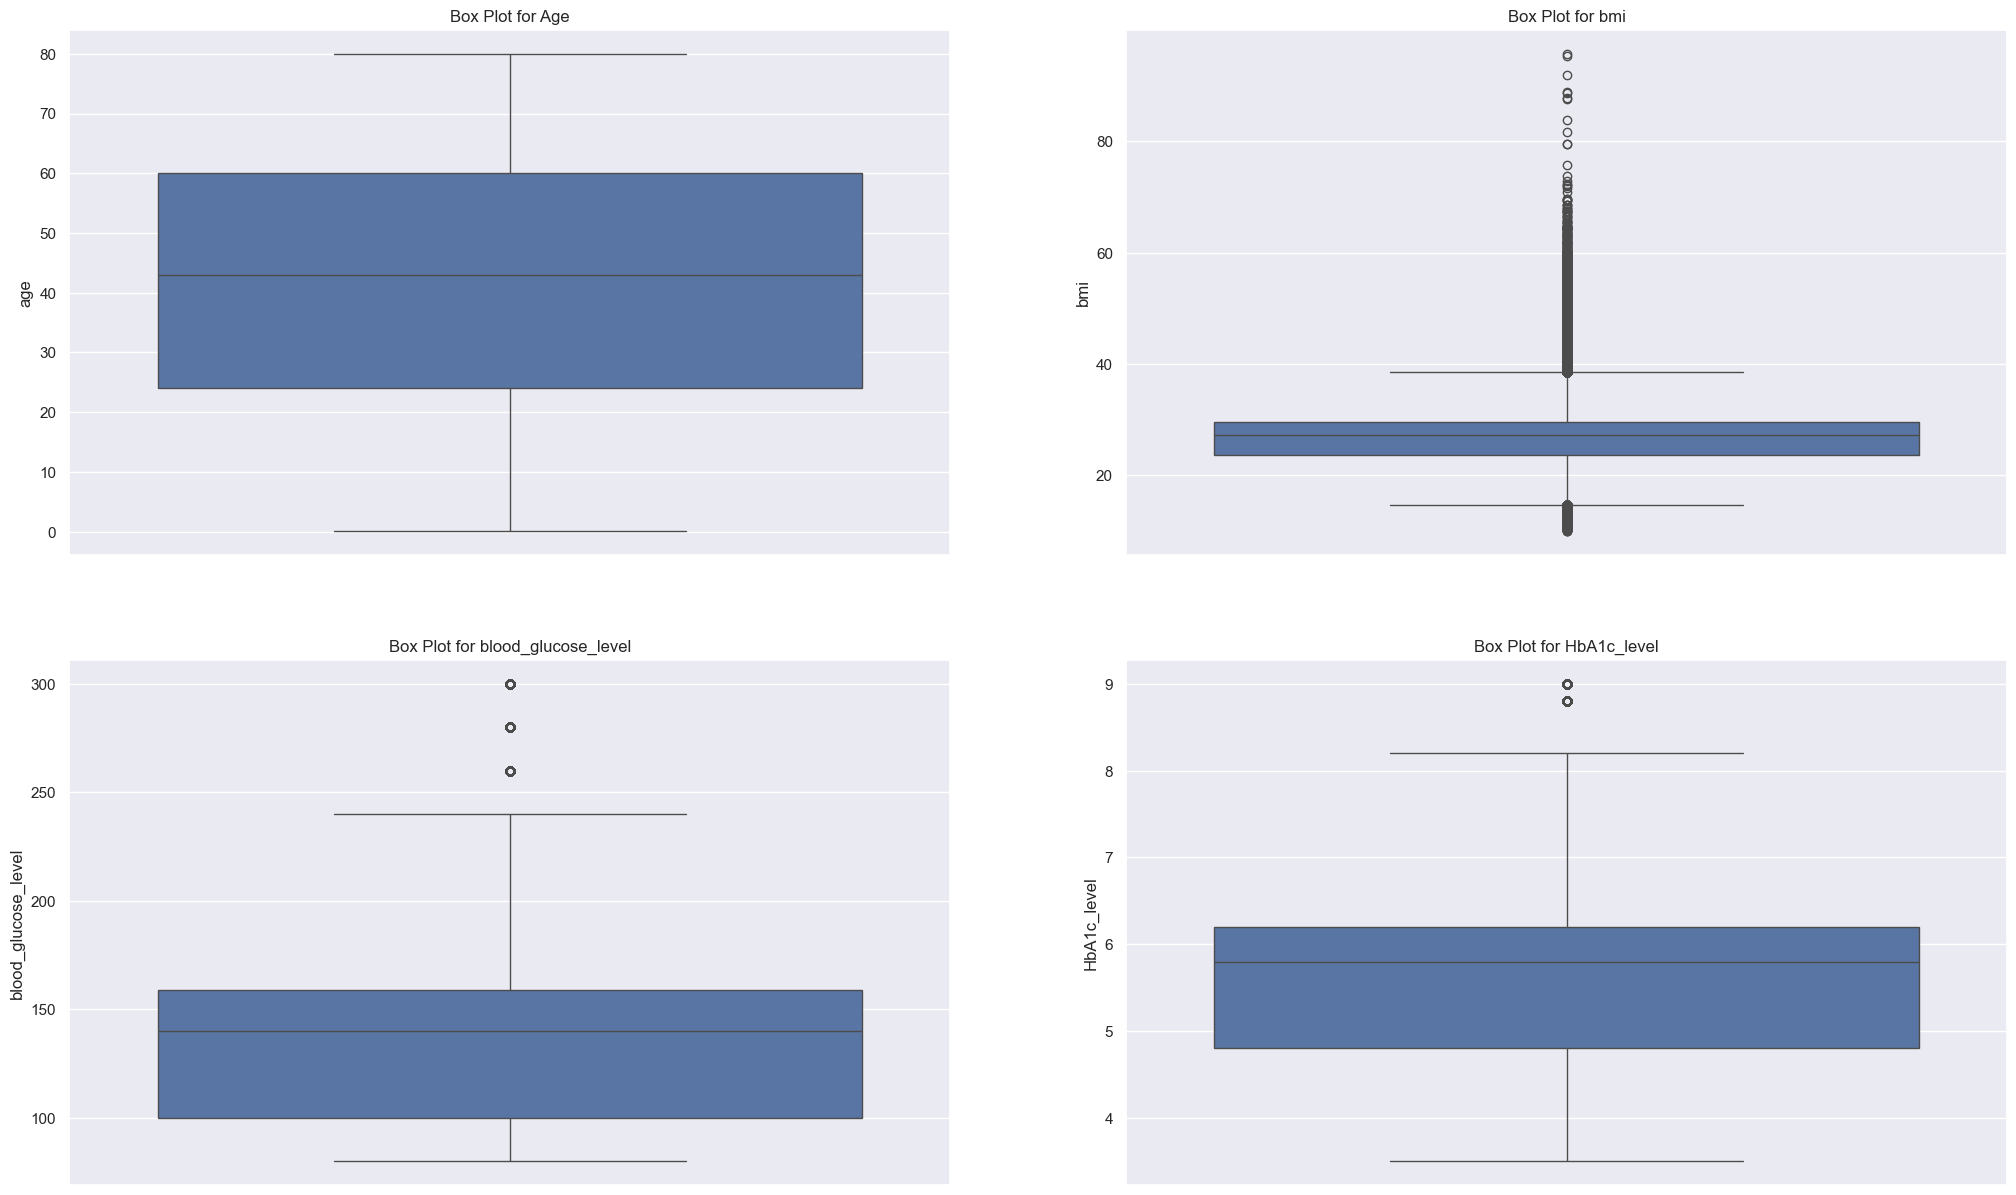

In [550]:
# Checking for outliers

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
sns.boxplot(y="age", data = df, ax=axs[0,0])
axs[0,0].set_title("Box Plot for Age")

sns.boxplot(y="bmi", data = df, ax=axs[0,1])
axs[0,1].set_title("Box Plot for bmi")

sns.boxplot(y="blood_glucose_level", data = df, ax=axs[1,0])
axs[1,0].set_title("Box Plot for blood_glucose_level")

sns.boxplot(y="HbA1c_level", data = df, ax=axs[1,1])
axs[1,1].set_title("Box Plot for HbA1c_level")

In [551]:
# Checking for duplicates
df.duplicated().sum()

3854

There are about 3854 duplicated data in our dataset, and will go ahead to drop them in the steps below, this is to ensure our data is clean and uphold the integrity of data used to train the model to be used for prediction.

In [553]:
# dropping the duplicates
df.drop_duplicates(inplace=True)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [554]:
# reconfirming duplicates
df.duplicated().sum()

0

All duplicates in the data set has been removed.

## Exploratory Data Analysis (EDA)
### Univariate Analysis

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64


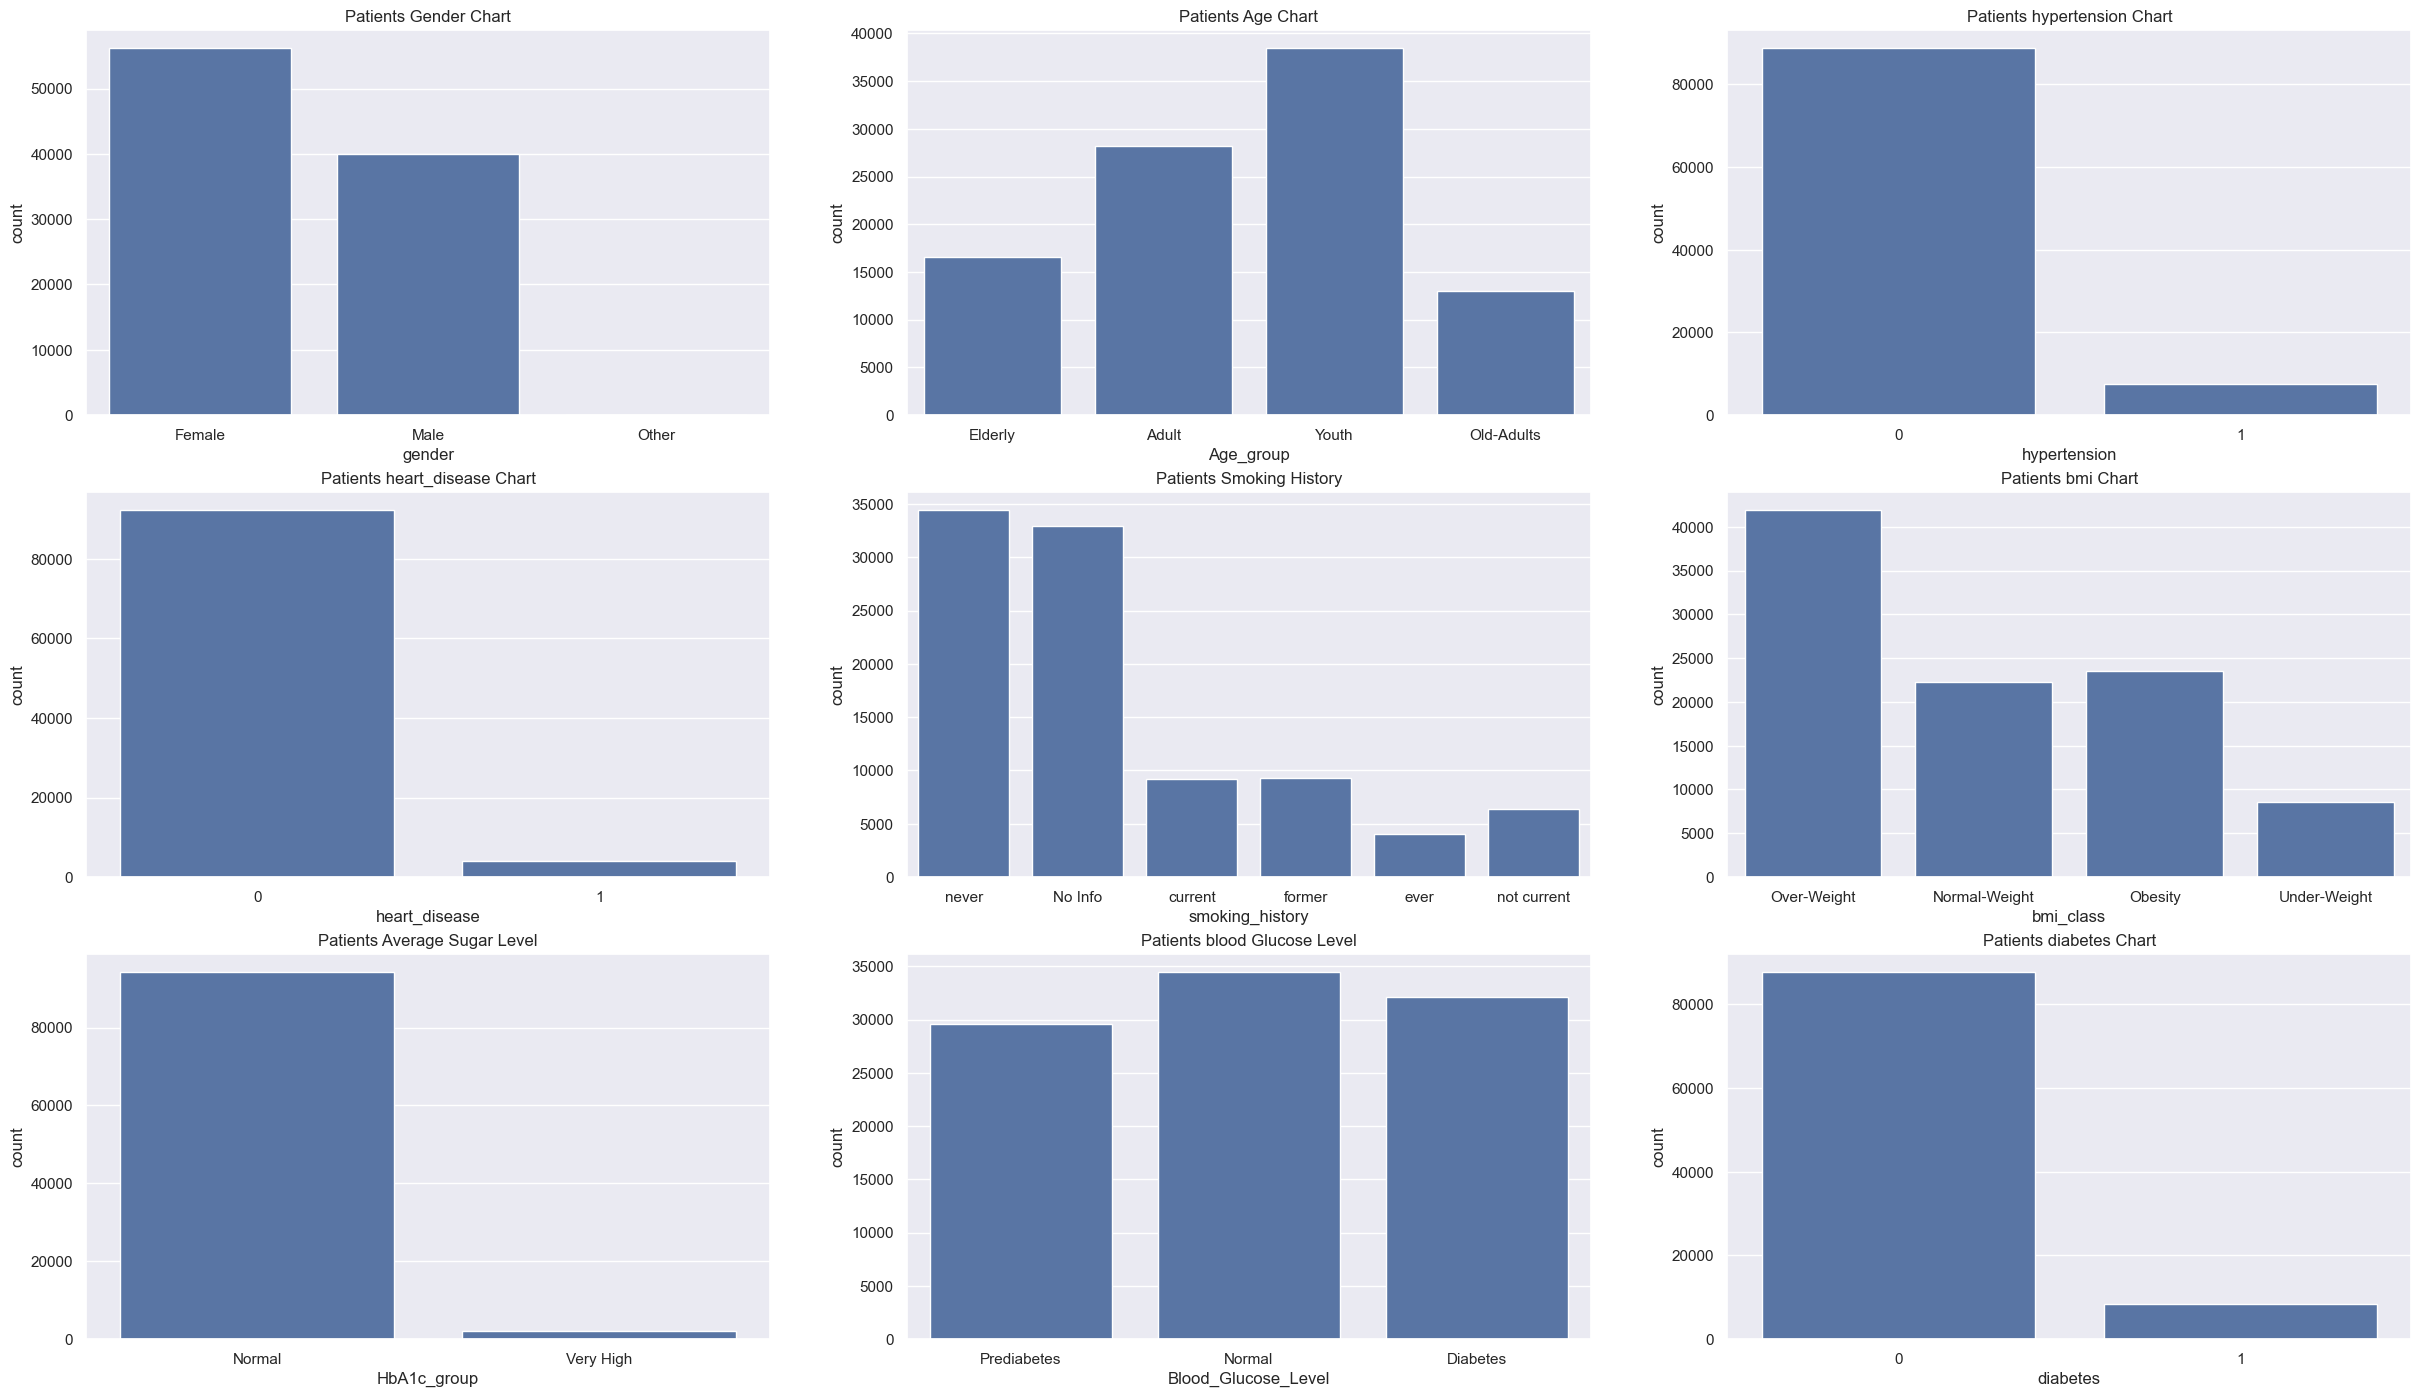

In [557]:
# Exploring the inidivual features of the dataset for possible insights

print(df["gender"].value_counts())

# Creating age and bmi group to enable categorize and visualize age in differet brackets
def age_grade(age):
    if age <= 35:
        return "Youth"
    elif age <=55:
        return "Adult"
    elif age <= 65:
        return "Old-Adults"
    else:
        return "Elderly"

df["Age_group"] = df["age"].apply(age_grade)    

def BMI_class(bmi):
    if bmi <= 18.5:
        return "Under-Weight"
    elif bmi <=25:
        return "Normal-Weight"
    elif bmi <= 30:
        return "Over-Weight"
    else:
        return "Obesity"

df["bmi_class"] = df["bmi"].apply(BMI_class)   

# Grouping Blood and Sugar levels for easy analysis and visualization using NHS diabetes chart standards
#https://blog.yodadiagnostics.com/wp-content/uploads/2023/11/3.png

def HbA1c_grade(hemo):
    if hemo <= 3:
        return "Very Low"
    elif hemo <=8:
        return "Normal"
    else:
        return "Very High"

df["HbA1c_group"] = df["HbA1c_level"].apply(HbA1c_grade)

def blood_glucose(gluc):
    if gluc <= 126:
        return "Normal"
    elif gluc <=155:
        return "Prediabetes"
    else:
        return "Diabetes"

df["Blood_Glucose_Level"] = df["blood_glucose_level"].apply(blood_glucose)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,17))
sns.countplot(x="gender", data=df, ax=axs[0,0])
axs[0,0].set_title("Patients Gender Chart")

sns.countplot(x= "Age_group", data=df, ax=axs[0,1])
axs[0,1].set_title("Patients Age Chart")

sns.countplot(x= "hypertension", data=df, ax=axs[0,2])
axs[0,2].set_title("Patients hypertension Chart")

sns.countplot(x= "heart_disease", data=df, ax=axs[1,0])
axs[1,0].set_title("Patients heart_disease Chart")

sns.countplot(x= "smoking_history", data=df, ax=axs[1,1])
axs[1,1].set_title("Patients Smoking History")

sns.countplot(x= "bmi_class", data=df, ax=axs[1,2])
axs[1,2].set_title("Patients bmi Chart")

sns.countplot(x="HbA1c_group", data=df, ax=axs[2,0])
axs[2,0].set_title("Patients Average Sugar Level")

sns.countplot(x= "Blood_Glucose_Level", data=df, ax=axs[2,1])
axs[2,1].set_title("Patients blood Glucose Level")

sns.countplot(x= "diabetes", data=df, ax=axs[2,2])
axs[2,2].set_title("Patients diabetes Chart");

The age feature shows slightly more female than male in our dataset, while the age group chart shows we have more patients in the Adult and Youth group under review in our data. 

The hypertension chart also reveals that a lot of patients under review are not hypertensive, neither do they have heart disease associated.

Reviewing the Smoking history chart, the majority of patients has never had a fag and also no information recorded for the next largest group(No info).

Majority of patients under review presented with over-weight BMI while slightly above the normal weighted are obese.

A lot of patients are within the Average Sugar Level margins while we have a lot more with pre-diabetes and diabetes status. 

In [559]:
# The smoking history feature has a bit more inconsistent data and needs to be reviewed or cleaned further.
df["smoking_history"] = df["smoking_history"].replace({"ever": "current", "former": "not current"})

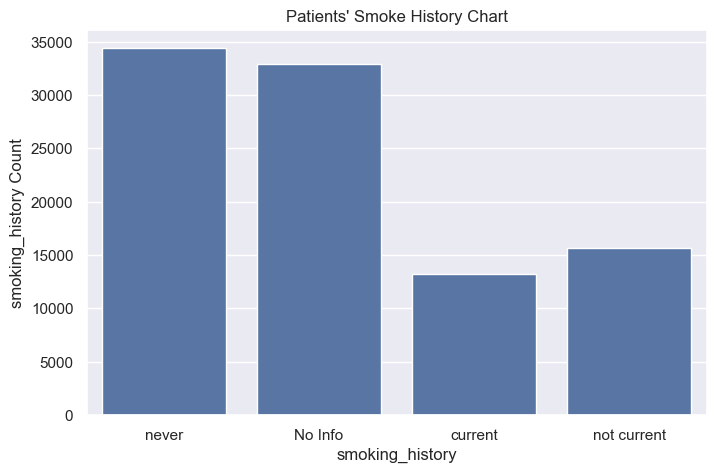

In [560]:
# Replaced inconsistent data visualizing the counts
df["smoking_history"].value_counts()
plt.figure(figsize=(8,5))
sns.countplot(x= df["smoking_history"], data=df)
plt.title("Patients' Smoke History Chart")
plt.ylabel("smoking_history Count")
plt.xlabel("smoking_history");

### Bivariate Analysis

In [562]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,Age_group,bmi_class,HbA1c_group,Blood_Glucose_Level
0,Female,80.0,0,1,never,25.19,6.6,140,0,Elderly,Over-Weight,Normal,Prediabetes
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,Adult,Over-Weight,Normal,Normal


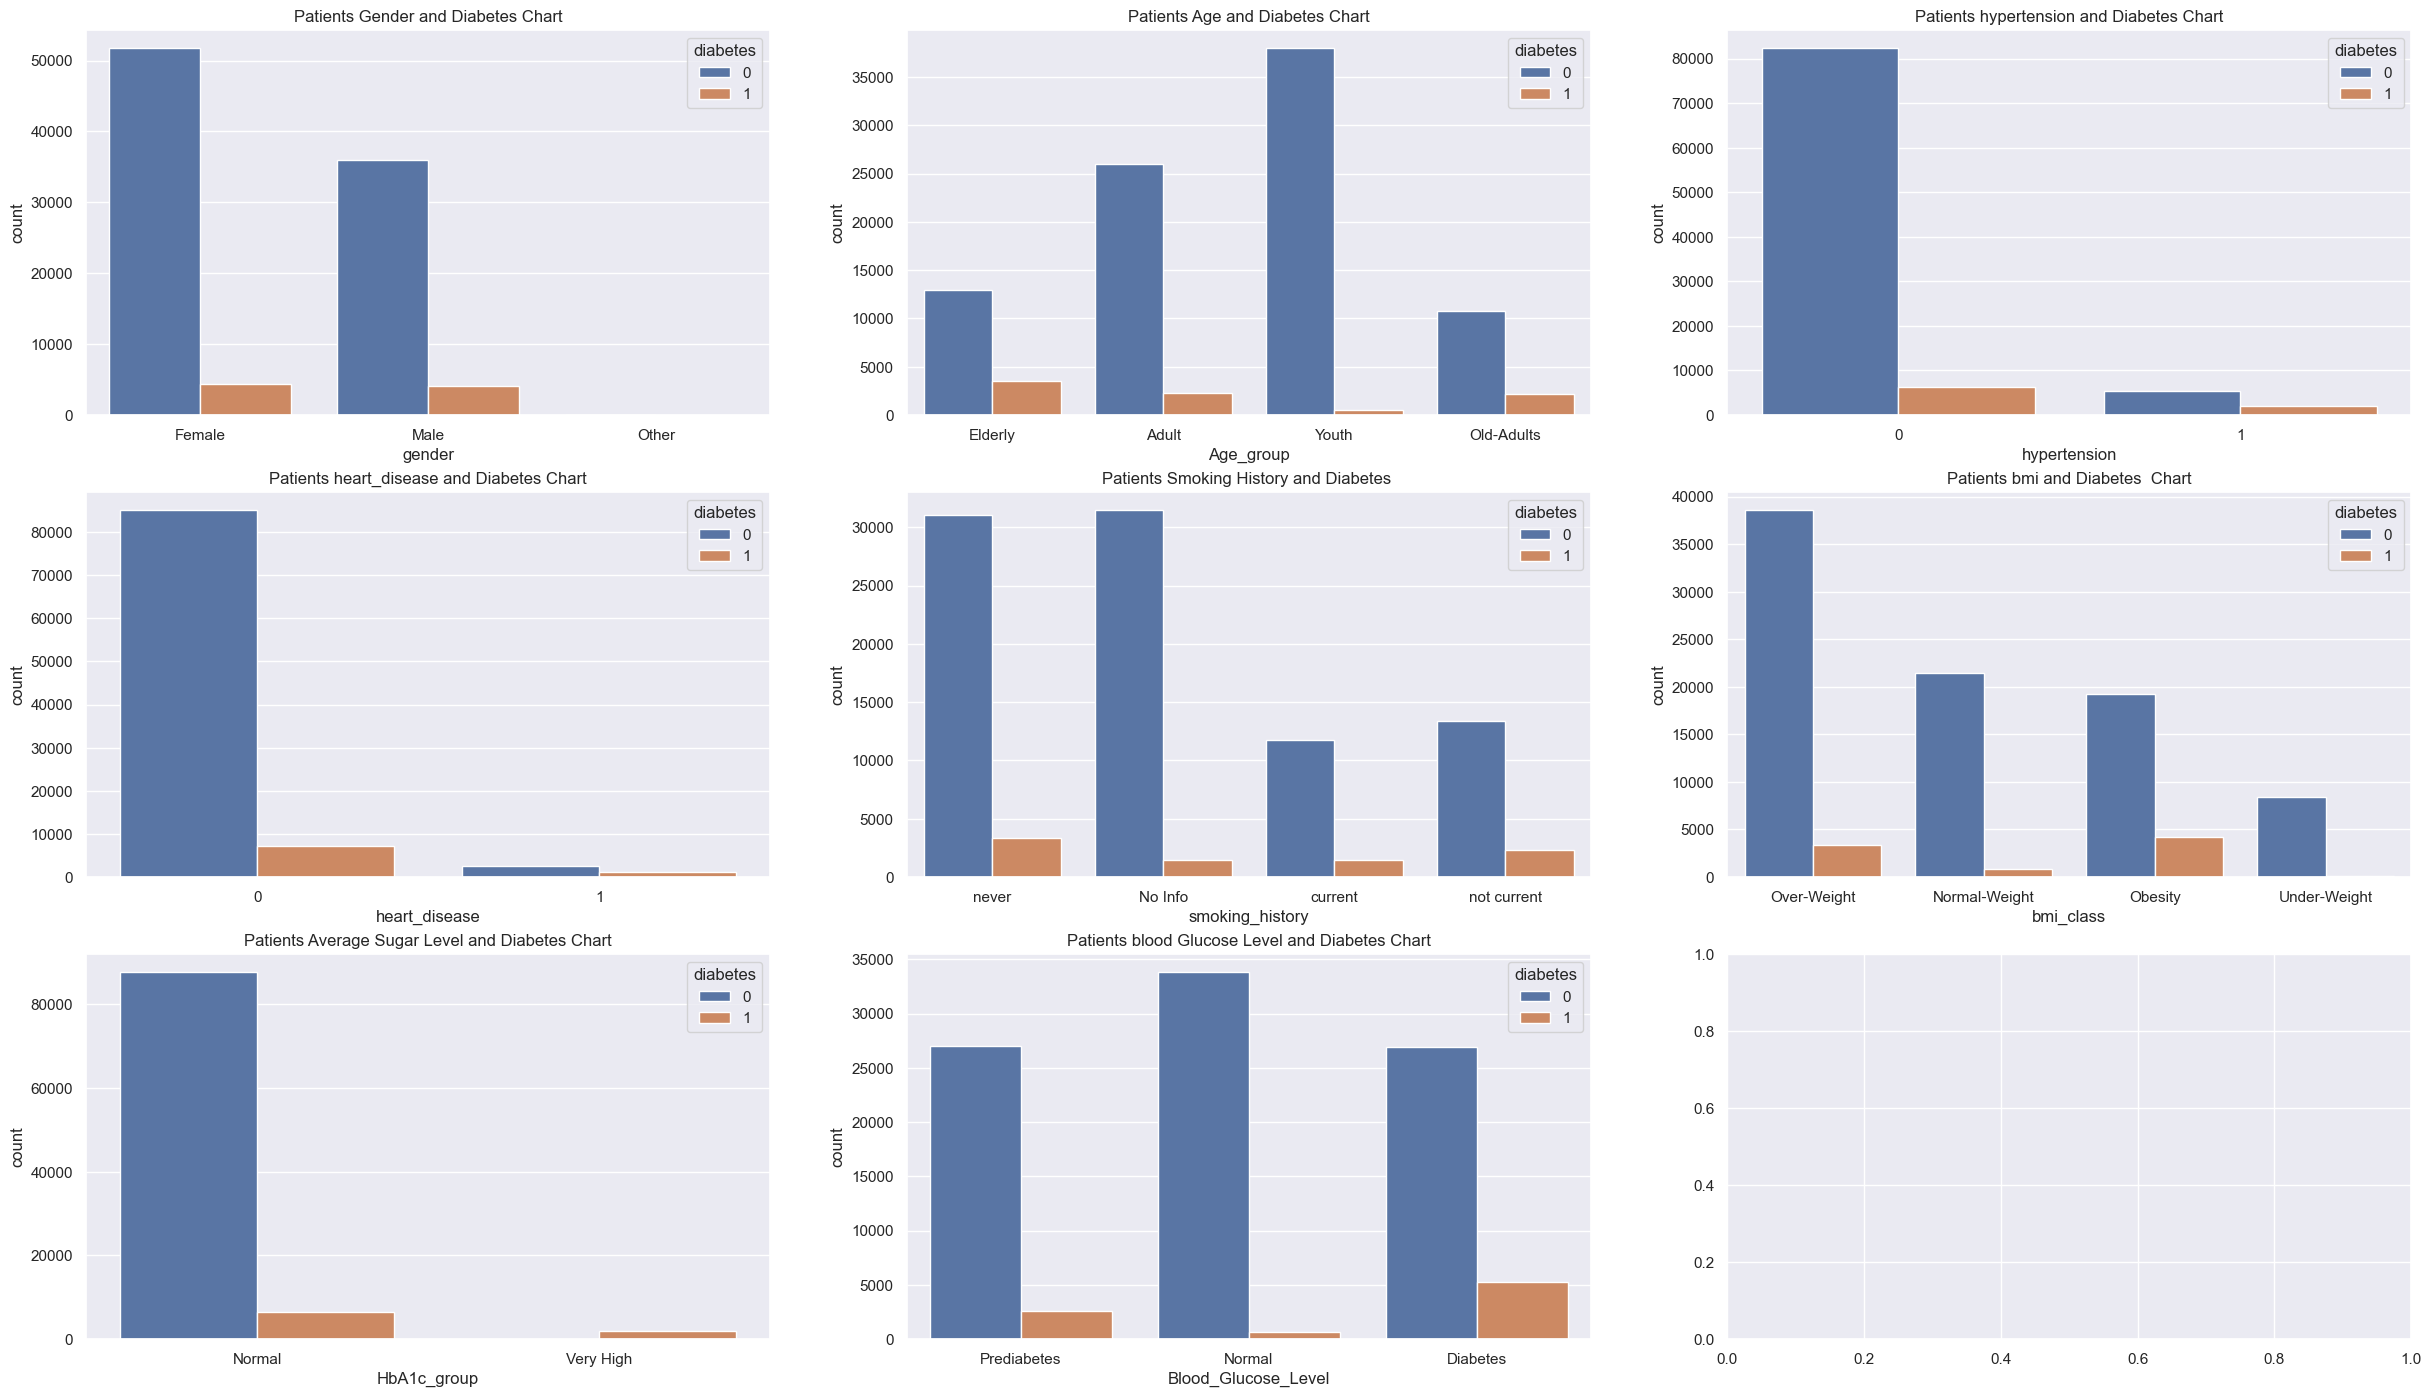

In [563]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,17))
sns.countplot(x="gender", data=df, hue="diabetes", ax=axs[0,0])
axs[0,0].set_title("Patients Gender and Diabetes Chart")

sns.countplot(x= "Age_group", data=df, hue="diabetes", ax=axs[0,1])
axs[0,1].set_title("Patients Age and Diabetes Chart")

sns.countplot(x= "hypertension", data=df, hue="diabetes", ax=axs[0,2])
axs[0,2].set_title("Patients hypertension and Diabetes Chart")

sns.countplot(x= "heart_disease", data=df, hue="diabetes", ax=axs[1,0])
axs[1,0].set_title("Patients heart_disease and Diabetes Chart")

sns.countplot(x= "smoking_history", data=df, hue="diabetes", ax=axs[1,1])
axs[1,1].set_title("Patients Smoking History and Diabetes ")

sns.countplot(x= "bmi_class", data=df, hue="diabetes", ax=axs[1,2])
axs[1,2].set_title("Patients bmi and Diabetes  Chart")

sns.countplot(x="HbA1c_group", data=df, hue="diabetes", ax=axs[2,0])
axs[2,0].set_title("Patients Average Sugar Level and Diabetes Chart")

sns.countplot(x= "Blood_Glucose_Level", data=df, hue="diabetes", ax=axs[2,1])
axs[2,1].set_title("Patients blood Glucose Level and Diabetes Chart");

Reviewig the individual features with diabetes column, a lot of the features have very low indication of dibetes as shown above, however this could be because
we have more patients without diabetes under review as the initial diabetes column reflected this unequal balance. 

In [565]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'Age_group',
       'bmi_class', 'HbA1c_group', 'Blood_Glucose_Level'],
      dtype='object')

In [566]:
# Dropping the extra columns
df.drop(columns = ['Age_group','HbA1c_group', 'Blood_Glucose_Level', 'bmi_class'], inplace=True)
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


In [567]:
#  Encoding the categorical variables using the label encoder

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for c in df.columns[0:]:
    if (df[c].dtypes=='object'):
        df[c] = encoder.fit_transform(df[c])
    else: 
        df[c] = df[c]

df.head()
    

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,2,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,2,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


In [568]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,0.416065,41.794326,0.077601,0.040803,1.341595,27.321461,5.532609,138.218231,0.088220
std,0.493287,22.462948,0.267544,0.197833,1.111263,6.767716,1.073232,40.909771,0.283616
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,2.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,2.000000,29.860000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.000000,1.000000,3.000000,95.690000,9.000000,300.000000,1.000000


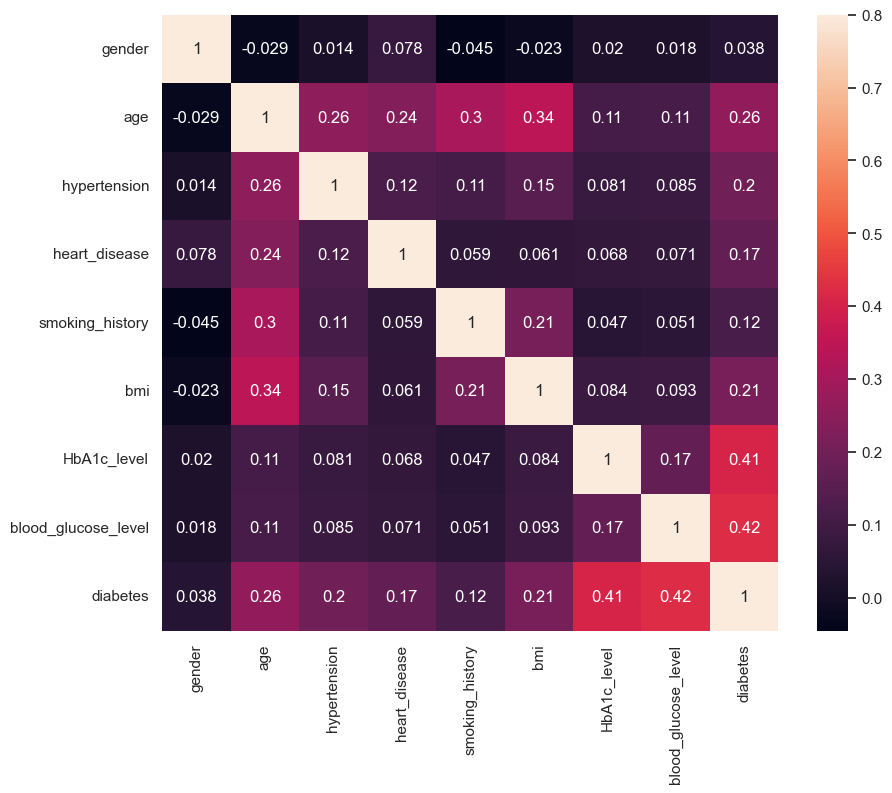

In [569]:
# Correlation between diabetes and other features
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmax=0.8, square = True, annot = True);

1 indicates a perfect positive correlation. -1 indicates a perfect negative correlation. while 0 indicates no correlation.
Key Positive Correlations: Diabetes is positively correlated with 
1. HbA1c_level (0.41): indicating that higher HbA1c levels are associated with a higher likelihood of diabetes.
2. Blood_glucose_level (0.42): Suggesting that increased blood glucose levels are a strong indicator of diabetes.
3. Age (0.26): Suggests that older individuals are slightly more likely to have diabetes.

Moderate Correlations
1. Bmi and age (0.34): Older individuals tend to have slightly higher BMI.
2. Bmi and smoking_history (0.21): Suggests a slight relationship between BMI and smoking history.
3. Age and smoking_history (0.3): suggests that Older individuals are more likely to have a smoking history.

Weak Correlations
Heart_disease has a weak correlation with all other variables, such as age (0.24), indicating a slight relationship. Hypertension and age (0.26) show a minor association.

Gender shows negligible correlation with most features, indicating no strong association between gender and other factors in this dataset.

In [571]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,2,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0


In [572]:
# Handling outliers using normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df["scaled_HbA1c_level"] = scaler.fit_transform(df["HbA1c_level"].values.reshape(-1,1))
df["scaled_blood_glucose_level"] = scaler.fit_transform(df["blood_glucose_level"].values.reshape(-1,1))
df["scaled_bmi"] = scaler.fit_transform(df["bmi"].values.reshape(-1,1))
df.drop(["HbA1c_level", "blood_glucose_level", "bmi"], axis = 1, inplace=True); 

In [573]:
df.head(2)

,gender,age,hypertension,heart_disease,smoking_history,diabetes,scaled_HbA1c_level,scaled_blood_glucose_level,scaled_bmi
0,0,80.0,0,1,2,0,0.563636,0.272727,0.177171
1,0,54.0,0,0,0,0,0.563636,0.000000,0.202031


### Machine Learning

In [575]:
# Separating the target variable form the rest
df1 = df[["gender",	"age",	"hypertension",	"heart_disease", "smoking_history",	"scaled_HbA1c_level", "scaled_blood_glucose_level",	"scaled_bmi"]]
Target = df[["diabetes",]]         

In [576]:
# Dividing the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(df, Target, test_size=0.2, random_state=42)

In [577]:
X_train

,gender,age,hypertension,heart_disease,smoking_history,diabetes,scaled_HbA1c_level,scaled_blood_glucose_level,scaled_bmi
46612,0,35.0,0,0,0,0,0.563636,0.340909,0.251167
31612,0,0.4,0,0,0,0,0.090909,0.227273,0.060458
96143,0,60.0,0,0,1,0,0.545455,0.090909,0.127101
95691,1,66.0,0,0,2,0,0.454545,0.227273,0.198880
37658,1,48.0,0,0,3,0,0.236364,0.295455,0.163866
...,...,...,...,...,...,...,...,...,...
6284,0,12.0,0,0,0,0,0.454545,0.363636,0.123133
56182,1,62.0,0,0,3,0,0.400000,0.363636,0.213936
79353,0,56.0,1,0,2,0,0.472727,0.545455,0.200864
860,0,37.0,0,0,2,0,0.490909,0.354545,0.174486


In [579]:
# Model Building

classifiers = [[XGBClassifier(), "XGB Classifier"],
                [RandomForestClassifier(), "Random Forest"],
                [KNeighborsClassifier(), "k-Nearest Neighbors"],
                [DecisionTreeClassifier(), "Decision Tree"],
                [LogisticRegression(), "Logistic Regression"]
              ]

In [580]:
acc_list={}
precision_list={}
recall_list={}
roc_list={}

# for loop
for classifier in classifiers:
    model = classifier[0]
    model.fit(X_train, y_train)
    model_name = classifier[1]
   
    #test
    pred = model.predict(X_test)
   
    # Assessing
    a_score = accuracy_score(y_test, pred)
    p_score = precision_score(y_test, pred)
    r_score = recall_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
   
    #converting into percentages
    acc_list[model_name] = ([str(round(a_score*100, 2))+ '%'])
    precision_list[model_name] = ([str(round(p_score*100, 2))+ '%'])
    recall_list[model_name] = ([str(round(r_score*100, 2))+ '%'])
    roc_list[model_name] = ([str(round(roc_score*100, 2))+ '%'])
   
    if model_name != classifiers[-1][1]:
        print('')

C:\Users\Admin\anacondanew\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


C:\Users\Admin\anacondanew\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


C:\Users\Admin\anacondanew\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [581]:
print("Accuracy Score")
s1=pd.DataFrame(acc_list)
s1

Accuracy Score


,XGB Classifier,Random Forest,k-Nearest Neighbors,Decision Tree,Logistic Regression
0,100.0%,100.0%,99.77%,100.0%,100.0%


In [582]:
print("Precision")
s2=pd.DataFrame(precision_list)
s2

Precision


,XGB Classifier,Random Forest,k-Nearest Neighbors,Decision Tree,Logistic Regression
0,100.0%,100.0%,100.0%,100.0%,100.0%


In [583]:
print("Recall")
s3=pd.DataFrame(recall_list)
s3

Recall


,XGB Classifier,Random Forest,k-Nearest Neighbors,Decision Tree,Logistic Regression
0,100.0%,100.0%,97.44%,100.0%,100.0%


In [584]:
print("ROC_Score")
s4=pd.DataFrame(roc_list)
s4

ROC_Score


,XGB Classifier,Random Forest,k-Nearest Neighbors,Decision Tree,Logistic Regression
0,100.0%,100.0%,98.72%,100.0%,100.0%


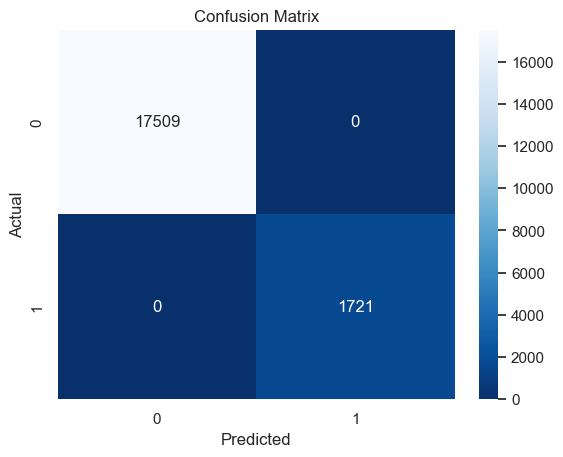

In [619]:
# Cofusion Matrix

rcm = confusion_matrix(y_test, rfy_pred)
#Visualizing the confusion matrix
sns.heatmap(rcm, annot=True, cmap="Blues_r", fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Confusion matrix
#rfc= RandomForestClassifier()
#rfc.fit(X_train, y_train)

#rfy_pred = rfc.predict(X_test)

#Visualizing the confusion matrix
#sns.heatmap(rcm, annot=True, cmap="Blues_r", fmt="g")
#plt.xlabel("Predicted")
#plt.ylabel("Actual")
#plt.title("Confusion Matrix")
#plt.show()